In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import warnings
warnings.filterwarnings("ignore")

<a id="1" ></a>
## Data Content
**Pregnancies :** Number of pregnancies

**Glucose :** Glucose rate in person

**BloodPressure :** Blood pressure in person

**SkinThickness :** Person's skin thickness

**Insulin :** Insulin rate in person

**BMI :** Body mass index

**DiabetesPedigreeFunction :** A function that calculates our chances of having diabetes based on people in our ancestry

**Age :** Age

**Outcome :** Information about whether the person has diabetes or not (1 with the disease, 0 not sick)


<a id="2" ></a>
## Read and Analyse Data

In [6]:
data = pd.read_csv("diabetes.csv") 
print("Success")

Success


In [7]:
def check(df):
    print("  Shape  ".center(50, "#"))
    print(df.shape)
    print("\n")
    print("  Types  ".center(50, "#"))
    print(df.dtypes)
    print("\n")
    print("  Head  ".center(50, "#"))
    print(df.head())
    print("\n")
    print("  Tail  ".center(50, "#"))
    print(df.tail())
    print("\n")
    print("  Nan  ".center(50, "#"))
    print(df.isnull().sum())
    print("\n")
    print("  Quantiles  ".center(50, "#"))
    print(df.quantile([0, 0.05, 0.5, 0.95, 1]).T)

check(data)

# Result: When we examine the data, we can see that it is numeric and float type. 
# It also does not contain missing data. When we examine the content of the variables, 
# the number of pregnancies being 17 is a suspicious situation, and glucose, blood pressure, 
# skin thickness, insulin height mass index min value should be examined as it is not possible 
# for a living person to have a min value of 0. In addition, although the insulin value was 519 at 99%, 
# the maximum value was 846, which raised suspicion of a discrete value because it was a sudden increase.

####################  Shape  #####################
(768, 9)


####################  Types  #####################
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object


#####################  Head  #####################
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                  

In [8]:
# Let's examine the data types
def analyze_columns(df, threshold1=10, threshold2=20):
    categoric_cols = [col for col in df.columns if df[col].dtype == "O"]
    numeric_categoric = [col for col in df.columns if df[col].nunique() < threshold1 and df[col].dtype != "O"]
    categoric_cardinal = [col for col in df.columns if df[col].nunique() > threshold2 and df[col].dtype == "O"]
    categoric_cols = categoric_cols + numeric_categoric
    categoric_cols = [col for col in categoric_cols if col not in categoric_cardinal]

    numeric_cols = [col for col in df.columns if df[col].dtype != "O"]
    numeric_cols = [col for col in numeric_cols if col not in numeric_categoric]

    print(f"Total Rows : {df.shape[0]}")
    print(f"Total Column: {df.shape[1]}")
    print(f"Total Categorical Column : {len(categoric_cols)}")
    print(f"Total Numeric Columns : {len(numeric_cols)}")
    print(f"Total Categorical Cardinal Column : {len(categoric_cardinal)}")
    print(f"Total Numeric Categorical Column : {len(numeric_categoric)}")
    return(numeric_cols)
analyze_columns(data)

Total Rows : 768
Total Column: 9
Total Categorical Column : 1
Total Numeric Columns : 8
Total Categorical Cardinal Column : 0
Total Numeric Categorical Column : 1


['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

In [9]:
# Relationship between variables and target variable
for col in data.columns[:-1]:
    print(f" {col} - Outcome ".center(30, "#"))
    print(data[[col, "Outcome"]].groupby([col]).mean().sort_values(by="Outcome")[::-1].head())
    print(data[[col, "Outcome"]].groupby([col]).mean().sort_values(by="Outcome")[::-1].tail())
    print("-"*25)


### Pregnancies - Outcome ####
              Outcome
Pregnancies          
17           1.000000
14           1.000000
15           1.000000
9            0.642857
11           0.636364
              Outcome
Pregnancies          
0            0.342342
4            0.338235
6            0.320000
1            0.214815
2            0.184466
-------------------------
##### Glucose - Outcome ######
         Outcome
Glucose         
199          1.0
181          1.0
149          1.0
198          1.0
156          1.0
         Outcome
Glucose         
127          0.0
191          0.0
157          0.0
110          0.0
99           0.0
-------------------------
## BloodPressure - Outcome ###
                Outcome
BloodPressure          
40             1.000000
114            1.000000
104            1.000000
102            1.000000
110            0.666667
               Outcome
BloodPressure         
44                 0.0
95                 0.0
38                 0.0
24                 0.0
122

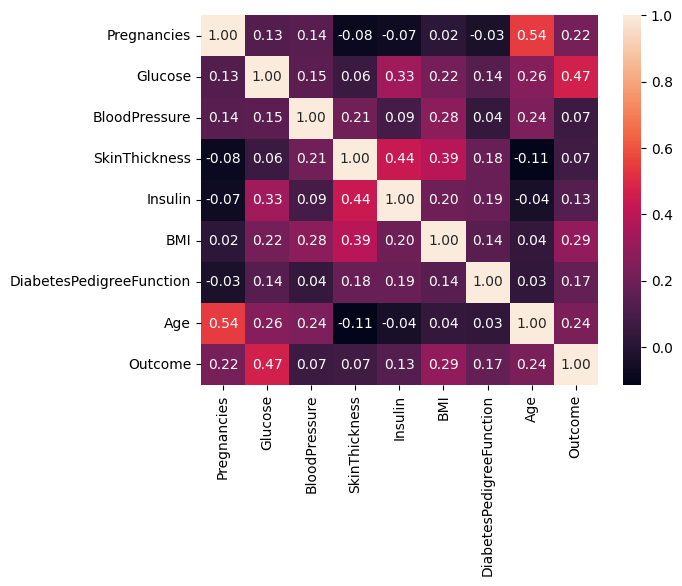

In [10]:
# Correlation check
sns.heatmap(data.corr(), annot=True, fmt=".2f")
plt.show()

<a id="3" ></a>
## Base Model

In [11]:
# Let's create a base model
X = data.drop("Outcome", axis=1)
y = data["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"Success score : {round(accuracy_score(y_test, y_pred), 2)}")

Success score : 0.77


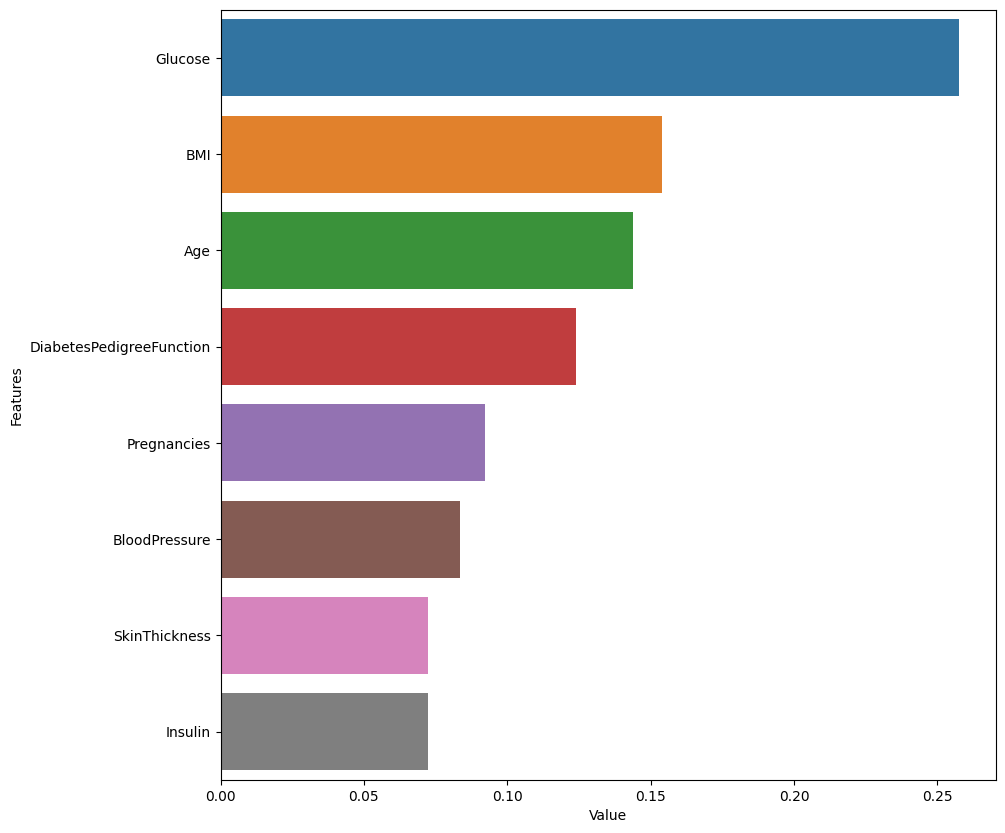

In [12]:
def plot_importance(model, features, num):
    feature_imp = pd.DataFrame({"Value" : model.feature_importances_, 
                                "Features" : features.columns})
    plt.figure(figsize=(10,10))
    sns.barplot(data=feature_imp.sort_values(by="Value", ascending=False)[0:num], x="Value", y="Features")
    plt.show()
plot_importance(model, X, len(X))
# Result: Glucose was the variable that had a high impact on the success of the model.

<a id="4" ></a>
## Missing Values

In [13]:
# Since variables other than Pregnancy and Outcome variables cannot have a value of 0, let's replace these variables with Nan.
zero_columns = [col for col in data.columns if(data[col].min() == 0 and col not in ["Pregnancies", "Outcome"])]
print(f"Columns containing zeros : {zero_columns}")

Columns containing zeros : ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']


In [14]:
for col in zero_columns:
    data[col] = np.where(data[col]==0, np.nan, data[col])
print("Success")

Success


In [15]:
# Let's look at the number of null values
data.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [16]:
# What is the rate of missing data? How valuable is it?
def missing_values(df):
    nan_columns = [col for col in df.columns if df[col].isnull().sum() > 0]
    num_miss = df[nan_columns].isnull().sum().sort_values(ascending=False)
    ratio = (df[nan_columns].isnull().sum() / df.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([num_miss, np.round(ratio, 2)], axis=1, keys=["missing_number", "ratio"])
    print(missing_df, end="\n")
    print(f"\nTotal Missing Values : {num_miss.sum()}\n")
missing_values(data)  
# Insulin missing data covers 48% of the data

               missing_number  ratio
Insulin                   374  48.70
SkinThickness             227  29.56
BloodPressure              35   4.56
BMI                        11   1.43
Glucose                     5   0.65

Total Missing Values : 652



In [17]:
# Do null values have any relation to the target variable?
for col in zero_columns:
    print(f" {col} - Outcome ".center(30, "#"))
    print(f"Number of Missing Values : {len(data.loc[data[col].isnull()])}")
    print(f"Number of Filled Values  : {len(data.loc[data[col].notnull()])}")
    mean_with_missing = data.loc[data[col].isnull(), "Outcome"].mean()
    print(f"Missing Value Rate : {round(mean_with_missing, 2)}")
    mean_without_missing = data.loc[data[col].notnull(), "Outcome"].mean()
    print(f"Occupied Value Rate : {round(mean_without_missing, 2)}")
    print("-"*30)
# Result: Null values for skin thickness and insulin do not affect many target variables.

##### Glucose - Outcome ######
Number of Missing Values : 5
Number of Filled Values  : 763
Missing Value Rate : 0.4
Occupied Value Rate : 0.35
------------------------------
## BloodPressure - Outcome ###
Number of Missing Values : 35
Number of Filled Values  : 733
Missing Value Rate : 0.46
Occupied Value Rate : 0.34
------------------------------
## SkinThickness - Outcome ###
Number of Missing Values : 227
Number of Filled Values  : 541
Missing Value Rate : 0.39
Occupied Value Rate : 0.33
------------------------------
##### Insulin - Outcome ######
Number of Missing Values : 374
Number of Filled Values  : 394
Missing Value Rate : 0.37
Occupied Value Rate : 0.33
------------------------------
####### BMI - Outcome ########
Number of Missing Values : 11
Number of Filled Values  : 757
Missing Value Rate : 0.18
Occupied Value Rate : 0.35
------------------------------


In [18]:
# Let's fill in the missing values
for col in zero_columns:
    data[col].fillna(data[col].median(), inplace=True)
print("Success")

Success


In [19]:
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

<a id="5" ></a>
## Outliers

In [20]:
def outlier_tresholds(df, col_name, q1=0.05, q3=0.95):
    quartiel1 = df[col_name].quantile(q1)
    quartiel3 = df[col_name].quantile(q3)
    quartiel_range = quartiel3 - quartiel1
    up = quartiel3 + 1.5*quartiel_range
    down = quartiel3 - 1.5*quartiel_range
    return(up, down)

def check_outlier(df, col_name):
    up, down = outlier_tresholds(df, col_name)
    filter = df[(df[col_name] > up) | (df[col_name] < down)].any(axis=None) 
    if(filter == True):
        return(True)
    else:
        return(False)

def replace_outliers(df, col_name, q1=0.05, q3=0.95):
    up, down = outlier_tresholds(df, col_name)
    df.loc[(df[col_name] < down), col_name] = down
    df.loc[(df[col_name] > up), col_name] = up

for col in data.columns:
    print(f"{col} : {check_outlier(data, col)}") 
    if(check_outlier(data, col)==True): 
        replace_outliers(data, col)

Pregnancies : False
Glucose : False
BloodPressure : True
SkinThickness : True
Insulin : True
BMI : False
DiabetesPedigreeFunction : False
Age : False
Outcome : False


In [21]:
# Let's check
print("-"*30)
for col in data.columns:
    print(f"{col} : {check_outlier(data, col)}")

------------------------------
Pregnancies : False
Glucose : False
BloodPressure : False
SkinThickness : False
Insulin : False
BMI : False
DiabetesPedigreeFunction : False
Age : False
Outcome : False


<a id="6"></a>
## Feature Extraction

In [22]:
data["New_Age"] = [1 if(i >= 21 and i < 50) else 0 for i in data["Age"]]
data["New_BMI"] = ["underweight" if(i <= 18.5) else "healthy" if(i > 18.5 and  i <= 24.9) else "overweight" if(i > 24.9 and i <=29.9) else "obese" for i in data["BMI"]]
data["New_Glucose"] = ["normal" if(i <= 140) else "prediabetes" if(i > 140 and  i < 190) else "diabetes" for i in data["Glucose"]]
data["New_Age_BMI"] = [
    "underweight_mature" if (j <= 18.5 and (i >= 21 and i < 50)) else
    "underweight_senior" if (j <= 18.5 and i >= 50) else
    "healthy_mature" if ((j > 18.5 and j <= 24.9) and (i >= 21 and i < 50)) else
    "healthy_senior" if ((j > 18.5 and j <= 24.9) and i >= 50) else
    "overweight_mature" if ((j > 24.9 and j <= 29.9) and (i >= 21 and i < 50)) else
    "overweight_senior" if ((j > 24.9 and j <= 29.9) and i >= 50) else
    "obese_mature" if (j > 18.5 and (i >= 21 and i < 50)) else
    "obese_senior" for i, j in zip(data["Age"], data["BMI"])
]
data["New_Age_Glucose"] = [
    "low_mature" if (j <= 70 and (i >= 21 and i < 50)) else
    "low_senior" if (j <= 70 and i >= 50) else
    "normal_mature" if ((j > 70 and j <= 100) and (i >= 21 and i < 50)) else
    "normal_senior" if ((j > 70 and j <= 100) and i >= 50) else
    "hidden_mature" if ((j > 100 and j <= 125) and (i >= 21 and i < 50)) else
    "hidden_senior" if ((j > 100 and j <= 125) and i >= 50) else
    "high_mature" if (j > 125 and (i >= 21 and i < 50)) else
    "high_senior" for i, j in zip(data["Age"], data["Glucose"])
]
data["New_Insulin"] = [1 if(i >= 16 and i <= 166) else 0 for i in data["Insulin"]]
data["Glıcose_Insulin"] = data["Glucose"] * data["Insulin"]
data["Glıcose_Pregnancies"] = data["Glucose"] * data["Pregnancies"]

data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,New_Age,New_BMI,New_Glucose,New_Age_BMI,New_Age_Glucose,New_Insulin,Glıcose_Insulin,Glıcose_Pregnancies
0,6,148.0,72.0,35.0,125.0,33.6,0.627,50,1,0,obese,prediabetes,obese_senior,high_senior,1,18500.0,888.0
1,1,85.0,66.0,29.0,125.0,26.6,0.351,31,0,1,overweight,normal,overweight_mature,normal_mature,1,10625.0,85.0
2,8,183.0,64.0,29.0,125.0,23.3,0.672,32,1,1,healthy,prediabetes,healthy_mature,high_mature,1,22875.0,1464.0
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,1,overweight,normal,overweight_mature,normal_mature,1,8366.0,89.0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,1,obese,normal,obese_mature,high_mature,0,23016.0,0.0


<a id="7" ></a>
## One-Hot-Encoder 

In [23]:
def one_hot_encoder(df, categorical_cols):
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    return(df)
colums = [col for col in data.columns if(10 >= data[col].nunique() > 2)]

data[colums].head()
data = one_hot_encoder(data, colums)
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,New_Age,...,New_Age_BMI_overweight_mature,New_Age_BMI_overweight_senior,New_Age_BMI_underweight_mature,New_Age_Glucose_hidden_senior,New_Age_Glucose_high_mature,New_Age_Glucose_high_senior,New_Age_Glucose_low_mature,New_Age_Glucose_low_senior,New_Age_Glucose_normal_mature,New_Age_Glucose_normal_senior
0,6,148.0,72.0,35.0,125.0,33.6,0.627,50,1,0,...,False,False,False,False,False,True,False,False,False,False
1,1,85.0,66.0,29.0,125.0,26.6,0.351,31,0,1,...,True,False,False,False,False,False,False,False,True,False
2,8,183.0,64.0,29.0,125.0,23.3,0.672,32,1,1,...,False,False,False,False,True,False,False,False,False,False
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,1,...,True,False,False,False,False,False,False,False,True,False
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,1,...,False,False,False,False,True,False,False,False,False,False


<a id="8"></a>
## Feature Scaling

In [24]:
numeric = analyze_columns(data)
scaler = RobustScaler()
data[numeric] = scaler.fit_transform(data[numeric])


Total Rows : 768
Total Column: 31
Total Categorical Column : 21
Total Numeric Columns : 10
Total Categorical Cardinal Column : 0
Total Numeric Categorical Column : 21


In [25]:
data.head() 

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,New_Age,...,New_Age_BMI_overweight_mature,New_Age_BMI_overweight_senior,New_Age_BMI_underweight_mature,New_Age_Glucose_hidden_senior,New_Age_Glucose_high_mature,New_Age_Glucose_high_senior,New_Age_Glucose_low_mature,New_Age_Glucose_low_senior,New_Age_Glucose_normal_mature,New_Age_Glucose_normal_senior
0,0.6,0.765432,0.000,0.857143,0.000000,0.142857,0.665359,1.235294,1,0,...,False,False,False,False,False,True,False,False,False,False
1,-0.4,-0.790123,-0.375,0.000000,0.000000,-0.626374,-0.056209,0.117647,0,1,...,True,False,False,False,False,False,False,False,True,False
2,1.0,1.629630,-0.500,0.000000,0.000000,-0.989011,0.783007,0.176471,1,1,...,False,False,False,False,True,False,False,False,False,False
3,-0.4,-0.691358,-0.375,-0.857143,-5.391304,-0.461538,-0.537255,-0.470588,0,1,...,True,False,False,False,False,False,False,False,True,False
4,-0.6,0.493827,-2.000,0.857143,7.478261,1.186813,5.007843,0.235294,1,1,...,False,False,False,False,True,False,False,False,False,False


<a id="9" ></a>
## Model Training

In [26]:
X = data.drop("Outcome", axis=1)
y = data["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"accuracy : {round(accuracy_score( y_test, y_pred), 2)}")

accuracy : 0.78


In [27]:
import xgboost as xgb
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"accuracy : {round(accuracy_score( y_test, y_pred), 2)}")

accuracy : 0.79


In [28]:
from sklearn.naive_bayes import GaussianNB 
model = GaussianNB()  
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"accuracy: {round(accuracy_score( y_test, y_pred), 2)}")

accuracy: 0.41


In [29]:
from sklearn.svm import SVC
model = SVC(kernel="rbf", gamma=0.5, C=1.0)  
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"accuracy : {round(accuracy_score( y_test, y_pred), 2)}")

accuracy : 0.71


In [30]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()  
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"accuracy : {round(accuracy_score( y_test, y_pred), 2)}")

accuracy : 0.76


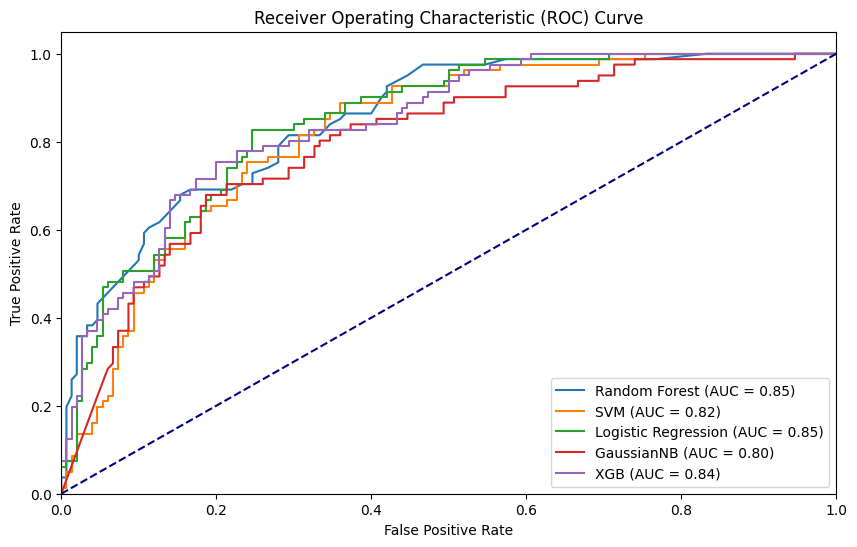

In [31]:
from sklearn.metrics import roc_curve, auc
classifiers = {
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "Logistic Regression": LogisticRegression(),
    "GaussianNB" : GaussianNB(),
    "XGB" : xgb.XGBClassifier()
}

# Plot ROC curves for each classifier
plt.figure(figsize=(10, 6))
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_score = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='%s (AUC = %0.2f)' % (name, roc_auc))

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

plt.show()

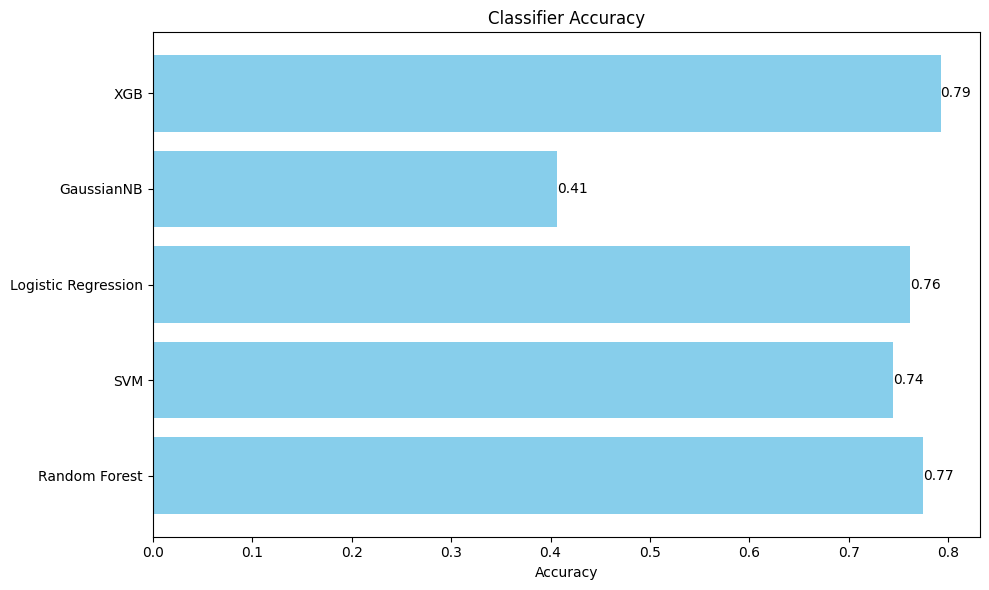

In [32]:
plt.figure(figsize=(10, 6))
accuracy_scores = []
bars = []
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append((name, accuracy))
    bar = plt.barh(name, accuracy, color='skyblue')
    bars.append(bar)
    plt.text(accuracy, bar[0].get_y() + bar[0].get_height()/2, f'{accuracy:.2f}', 
             va='center', ha='left')

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

plt.tight_layout()
plt.show()

In [33]:
def plot_importance(model, features, num):
    feature_imp = pd.DataFrame({"Value" : model.feature_importances_, 
                                "Features" : features.columns})
    plt.figure(figsize=(10,10))
    sns.barplot(data=feature_imp.sort_values(by="Value", ascending=False)[0:num], x="Value", y="Features")
    plt.show()
plot_importance(model, X, len(X))
# Result: Glucose*Insulin took its place as the variable that highly affects the success of the model.
# New_Age_Glucose has become a variable that reduces success, so it should be removed and evaluated

AttributeError: 'LogisticRegression' object has no attribute 'feature_importances_'